Ziel ist zu beobachten: not MAP <=> ties

In [259]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4589)
# np.seterr(all="raise")
np.seterr(all="warn")

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [260]:
import snippets
import BeliefPropagation
import BinaryBP

In [261]:
num_cws = 100000
EbN0 = 2
max_iters = 600
rx, adjacency_matrix, log_factors = snippets.random_symbol_detection_ising_model(num_cws, sigma=0.1)
factors = np.exp(log_factors)

#bp = BeliefPropagation.BeliefPropagation(adjacency_matrix, 2)
bp = BinaryBP.BinaryBP(adjacency_matrix)

c_var = bp.c_var_DefaultCBP()
print(c_var)
gamma = bp.gammaDefaultCBP()
print(gamma)


[-2.  -2.5 -2.5 -2. ]
[1.         1.14285714 1.14285714 1.        ]


Compute MPA assignment for converged cases

In [262]:
var_beliefs = np.empty((num_cws, 4, 2))
check_beliefs = np.empty((num_cws, bp.m) + bp.df_max * (2,))
iterations = np.empty(var_beliefs.shape[0])
for cw_idx in range(var_beliefs.shape[0]):
    (var_beliefs[cw_idx,:], check_beliefs[cw_idx,:], _, iterations[cw_idx]) = bp.run_belief_propagation(
        max_iters=max_iters,
        convergence_threshold=1e-12,
        factors=factors[cw_idx],
        max_product=True,
        gamma=gamma,
        damping=0.5
    )
converged = iterations < max_iters
converged_cnt = np.sum(converged)
print(f"{converged_cnt / num_cws * 100}% converged ({converged_cnt}/{num_cws})")
mpa_assignment = np.argmax(var_beliefs[converged,:], axis=2) # decode with beliefs

96.91% converged (96910/100000)


Compute MAP assignment for converged cases and compare

In [263]:
map_assignment = snippets.bruteforce_MAP_symbol_detection(rx[converged,:])
mpa_unequal_map = np.sum(np.logical_xor(mpa_assignment, map_assignment), axis=1) > 0
mpa_unequal_map_cnt = np.sum(mpa_unequal_map)
print(f"MPA unequal MAP {mpa_unequal_map_cnt / converged_cnt * 100} % ({mpa_unequal_map_cnt}/{converged_cnt})")

MPA unequal MAP 0.22598287070477763 % (219/96910)


unequal LLR maximum: 89.32298392541033 / equal LLR minimum: 0.0003295551983519819


/tmp/ipykernel_4119/918364676.py:1: RuntimeWarning: divide by zero encountered in divide
  min_abs_llr = np.min(np.abs(np.log(var_beliefs[converged][:,:,0] / var_beliefs[converged][:,:,1])), axis=1)
/tmp/ipykernel_4119/918364676.py:1: RuntimeWarning: divide by zero encountered in log
  min_abs_llr = np.min(np.abs(np.log(var_beliefs[converged][:,:,0] / var_beliefs[converged][:,:,1])), axis=1)


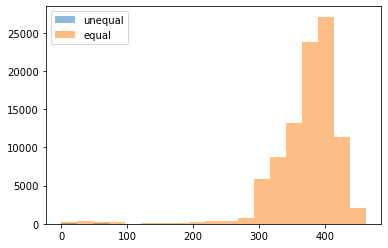

In [264]:
min_abs_llr = np.min(np.abs(np.log(var_beliefs[converged][:,:,0] / var_beliefs[converged][:,:,1])), axis=1)

unequal_llrs = min_abs_llr[mpa_unequal_map]
equal_llrs = min_abs_llr[np.logical_not(mpa_unequal_map)]
print(f"unequal LLR maximum: {np.max(unequal_llrs)} / equal LLR minimum: {np.min(equal_llrs)}")

hist_max = (np.max(unequal_llrs[unequal_llrs < float('inf')]) if np.any(unequal_llrs < float('inf')) > 0 else 0)  + np.average(equal_llrs[equal_llrs < float('inf')])
bins = np.linspace(0, hist_max, 20)
plt.hist(unequal_llrs, bins, alpha=0.5, label="unequal")
plt.hist(equal_llrs, bins, alpha=0.5, label="equal")
plt.legend()
plt.show()

In [265]:
marginalisation_constraint = np.zeros(converged_cnt)
admissibility_constraint = np.zeros(converged_cnt)
for cw in range(converged_cnt):
    marginalisation_constraint[cw] = bp.satisfyMarginalization(var_beliefs[converged][cw], check_beliefs[converged][cw], max=True, atol=1e-4)
    admissibility_constraint[cw] = bp.satisfyAdmissibility(var_beliefs[converged][cw], check_beliefs[converged][cw], c_var, factors[cw], atol=1e-3)

print(marginalisation_constraint)
print(admissibility_constraint)

KeyboardInterrupt: 